## Smart home models

This is to develop and test smart home situation awarenes models and Python implementations. 

### 1. States and phase spaces

Candidate for state spaces (for Markov model or Bayesian network) is a product space of the following factors:
- $S_i$: appliances with two states at least: on, off
- Situation event $A$: like absent, present at home

The state space is then
$$ S = S_1 \times S_2\times\cdots = \{(s_1, s_2, \ldots): s_i\in H_i\}, $$
$H_i=\{0, 1, \ldots\}$ is a state space of $i$-th appliance. where $0$ is no and $1$ is yes. Therefore, for N applicances we have $k^N$ states labeles as n-nary numbers from $0$ to $k^{N-1}$, that is
$$ 0 0 \ldots 0 $$
$$ 0 1 \ldots 0 $$
$$ 0 2 \ldots 0 $$
$$ \cdots $$
$$ 1 1 \ldots 1 $$


#### Note: How to use Graphviz in VSC:
- install with "Add path"
- install https://marketplace.visualstudio.com/items?itemName=EFanZh.graphviz-preview
- create .dot file and pen the Command Palette (usually by pressing Ctrl + Shift + P), then select “Graphviz: Open Preview to the Side”.


### 2. Hidden markov model

Based on blog https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7

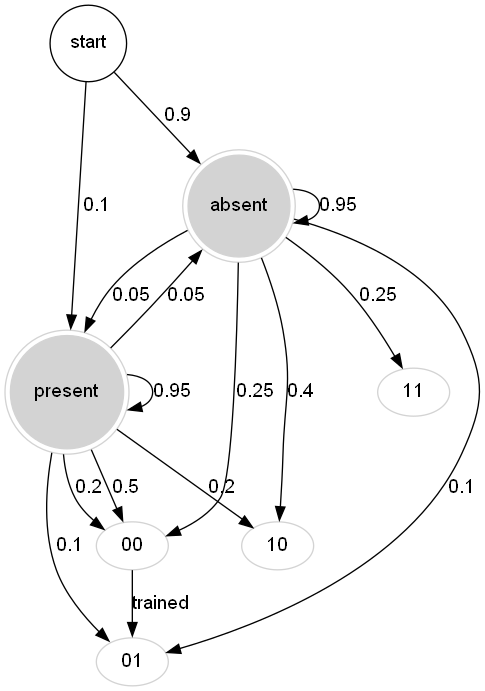







## 3. HMM model of smart home

In [2]:
# By https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_multinomial_hmm.html#sphx-glr-auto-examples-plot-multinomial-hmm-py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm

# Funs
def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home sitation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
ostates2id = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])


# Observations of states - a sequence of sampled states at home, obtained from real data
observations = [['00', '01', '01', '10', '01'],
        ['10', '01', '01', '10', '01'],
        ['00', '01', '01', '00', '01'],
        ['10', '01', '10', '10', '00'],
        ['00', '11', '01', '10', '00'],
        ['00', '11', '11', '10', '11'],
        ['11', '11', '11', '10', '00'],
        ['10', '01', '10', '10', '00'],
        ['00', '01', '01', '00', '01'],
        ['11', '11', '11', '11', '11']]

# Format observations
X = []
for status in observations:
    row = sequence2counts(status, ostates2id)
    X.append(row)
data = np.array(X, dtype=int)

# Multiply observations (remove later)
lengths = [len(X)]*5
sequences = np.tile(data, (5,1))


# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=len(observations[0]),
        n_iter=50,
        init_params='')

model.n_features = len(o_states)
model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs
model.fit(sequences, lengths)


# Estimate state
logprob, state_ests = model.decode(sequences)



MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [3]:
state_ests

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0])

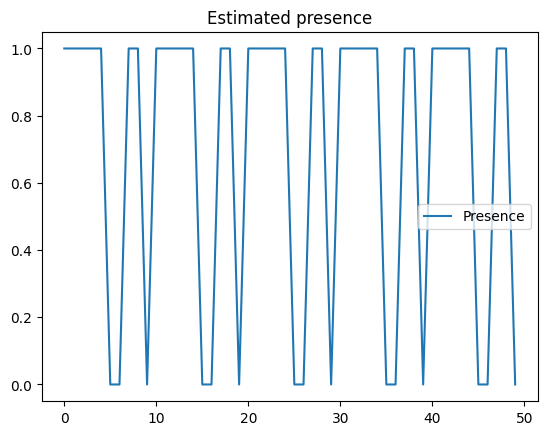

In [4]:
time = range(len(state_ests))
ests_df = pd.DataFrame(data=state_ests, index=time, columns=['Presence'])
g = sns.lineplot(data=ests_df).set(title='Estimated presence')

In [5]:
# Print states
print("Estimated states")
print([id2hstates[x] for x in state_ests])

print("Learned emission probs:")
print(model.emissionprob_)

print("Learned transition matrix:")
print(model.transmat_)

Estimated states
['present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'present', 'present', 'absent', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'present', 'present', 'absent', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'present', 'present', 'absent', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'present', 'present', 'absent', 'present', 'present', 'present', 'present', 'present', 'absent', 'absent', 'present', 'present', 'absent']
Learned emission probs:
[[1.33342061e-01 1.85375720e-05 1.33324771e-01 7.33314630e-01]
 [2.57131630e-01 4.28537568e-01 2.85708740e-01 2.86220619e-02]]
Learned transition matrix:
[[0.49989344 0.50010656]
 [0.2856972  0.7143028 ]]


## 4. Next steps

1. Integration of HMM into 
- sampling data and default
- visualisation

2. Evaluation using sklearn

We obtain machine learning evaluation:
- ROC curves
- time accuracy 

3. Competitive ML model: SVN
- the SVN classifier trains ground truth on data
- we evaluate in the same way as HMM

4. Integrate new appliances

#### Some links
- "Folding": https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
- Confusion matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- F1 mera: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
- AUC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
- ROC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- Strojno učenje: https://scikit-learn.org/stable/modules/classes.html


### Notes

1. After rules modeled by random procesess also use classic AI like SVM or decission forests
2. Prepare a paper for Smart home situation awareness 